# "Holding Constant" Made Visual

**Business Question**: How do penguin body measurements relate to each other?

This notebook demonstrates the concept of "holding constant" in multiple regression by visualizing how the effect of one predictor changes when we control for another predictor. We'll use penguin body measurements to make this abstract concept concrete and visual.


## Learning Objectives

By the end of this notebook, you will be able to:
- Understand what "holding constant" means in multiple regression
- Visualize partial effects through 3D plots and slices
- Compare simple vs multiple regression coefficients
- Interpret why coefficients change when adding predictors
- See how Simpson's paradox can occur in real data


In [7]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")


## Data Exploration

**What we're doing here:** We're loading a dataset about penguins and getting familiar with what information we have. This is like looking at a spreadsheet before we start analyzing it.

**Why this matters:** Before we can understand how penguin measurements relate to each other, we need to know what data we're working with. Think of this as "getting to know your data" - like reading the ingredients before cooking a recipe.


In [8]:
# Load penguins dataset
# This line downloads a dataset about penguins from the internet
# It's like opening a file that contains information about 344 penguins
penguins = sns.load_dataset('penguins')

# Clean data (remove missing values)
# Some penguins might be missing measurements - we remove those rows
# This is like throwing away incomplete surveys before analyzing them
penguins_clean = penguins.dropna()

# Let's see what we have
print("Dataset shape:", penguins_clean.shape)
print("This tells us: 333 penguins, 7 pieces of information about each")
print("\nFirst 5 rows:")
print(penguins_clean.head())
print("This shows us the first 5 penguins and all their measurements")

print("\nSpecies distribution:")
print(penguins_clean['species'].value_counts())
print("This shows how many penguins of each type we have")

# Focus on numerical variables (measurements we can do math with)
numerical_vars = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
print(f"\nNumerical variables: {numerical_vars}")
print("These are the measurements we'll use in our analysis")
print("\nBasic statistics:")
print(penguins_clean[numerical_vars].describe())
print("This gives us the average, min, max, and spread of each measurement")


Dataset shape: (333, 7)
This tells us: 333 penguins, 7 pieces of information about each

First 5 rows:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
4       3450.0  Female  
5       3650.0    Male  
This shows us the first 5 penguins and all their measurements

Species distribution:
species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64
This shows how many penguins of each type we have

Numerical variables: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'bo

## Step 1: Simple Regression First

**What we're doing here:** We're starting with the simplest possible analysis - looking at how just ONE thing (flipper length) relates to body mass. This is like asking "Do penguins with longer flippers weigh more?"

**Why we start simple:** Before we can understand complex relationships, we need to understand basic ones. It's like learning to walk before you run.

**What you'll learn:** How to read regression results and what the numbers mean in plain English.


Simple Regression: Body Mass ~ Flipper Length
This is the mathematical relationship between flipper length and body mass
                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1060.
Date:                Tue, 21 Oct 2025   Prob (F-statistic):          3.13e-105
Time:                        13:26:14   Log-Likelihood:                -2461.1
No. Observations:                 333   AIC:                             4926.
Df Residuals:                     331   BIC:                             4934.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---

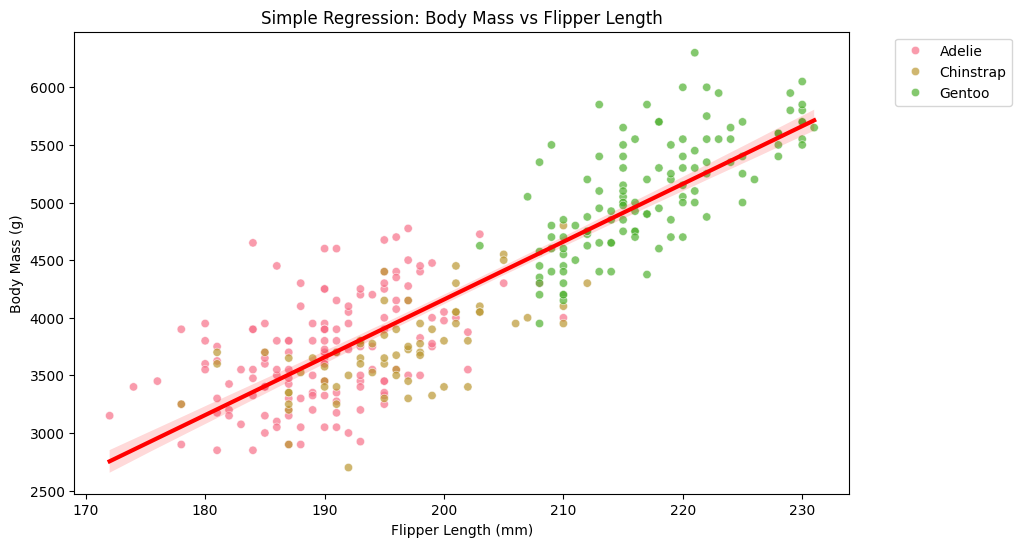


Simple regression coefficient: 50.15
This number tells us: For every 1mm increase in flipper length,
body mass increases by 50.2 grams on average

Think of it like: Longer flippers = Heavier penguins


In [9]:
# Simple regression: body_mass_g ~ flipper_length_mm
# This line asks: "How does flipper length predict body mass?"
# The ~ symbol means "predicted by" - so we're saying "body mass predicted by flipper length"
simple_model = ols("body_mass_g ~ flipper_length_mm", data=penguins_clean).fit()

print("Simple Regression: Body Mass ~ Flipper Length")
print("="*50)
print("This is the mathematical relationship between flipper length and body mass")
print(simple_model.summary())

# Visualize simple regression
# This creates a picture to help us see the relationship
plt.figure(figsize=(10, 6))

# First, we plot each penguin as a dot
# The x-axis is flipper length, y-axis is body mass
# Different colors show different species
sns.scatterplot(data=penguins_clean, x='flipper_length_mm', y='body_mass_g', 
                hue='species', alpha=0.7)

# Then we draw the "best fit line" - the line that best describes the relationship
sns.regplot(data=penguins_clean, x='flipper_length_mm', y='body_mass_g', 
            scatter=False, color='red', line_kws={'linewidth': 3})

plt.title('Simple Regression: Body Mass vs Flipper Length')
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Body Mass (g)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Now let's interpret what the numbers mean
print(f"\nSimple regression coefficient: {simple_model.params['flipper_length_mm']:.2f}")
print("This number tells us: For every 1mm increase in flipper length,")
print("body mass increases by {:.1f} grams on average".format(
    simple_model.params['flipper_length_mm']))
print("\nThink of it like: Longer flippers = Heavier penguins")


## Step 2: Add Second Predictor

**What we're doing here:** Now we're adding a second measurement (bill depth) to our analysis. This is like asking "Do penguins with longer flippers weigh more, AND do penguins with deeper bills weigh more?"

**Why this matters:** In real life, multiple things affect outcomes. A penguin's weight might depend on BOTH flipper length AND bill depth. We need to account for both.

**The key insight:** When we add the second variable, the coefficient for flipper length might change! This is the "holding constant" effect we're about to explore.


In [10]:
# Multiple regression: body_mass_g ~ flipper_length_mm + bill_depth_mm
# Now we're asking: "How do BOTH flipper length AND bill depth predict body mass?"
# The + symbol means "and also" - so we're including both variables
multiple_model = ols("body_mass_g ~ flipper_length_mm + bill_depth_mm", data=penguins_clean).fit()

print("Multiple Regression: Body Mass ~ Flipper Length + Bill Depth")
print("="*60)
print("This shows the relationship when we consider BOTH variables together")
print(multiple_model.summary())

# Compare coefficients
print("\nCoefficient Comparison:")
print("="*40)
print("Let's see how the flipper length coefficient changed when we added bill depth:")
print(f"Simple regression (flipper only): {simple_model.params['flipper_length_mm']:.2f}")
print(f"Multiple regression (flipper):    {multiple_model.params['flipper_length_mm']:.2f}")
print(f"Multiple regression (bill depth): {multiple_model.params['bill_depth_mm']:.2f}")

# Show how coefficients changed
flipper_change = multiple_model.params['flipper_length_mm'] - simple_model.params['flipper_length_mm']
print(f"\nFlipper coefficient changed by: {flipper_change:.2f}")
print("This change happened because we're now 'holding bill depth constant'")
print("In other words: 'What's the effect of flipper length when bill depth stays the same?'")
print("\nThis is the magic of multiple regression - it isolates the effect of each variable!")


Multiple Regression: Body Mass ~ Flipper Length + Bill Depth
This shows the relationship when we consider BOTH variables together
                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     533.2
Date:                Tue, 21 Oct 2025   Prob (F-statistic):          4.28e-104
Time:                        13:26:15   Log-Likelihood:                -2460.0
No. Observations:                 333   AIC:                             4926.
Df Residuals:                     330   BIC:                             4937.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0

## Step 3: The Magic - "Holding Constant" Visualization

**What we're doing here:** We're creating a 3D picture to show exactly what "holding constant" means. This is the most important part of understanding multiple regression!

**Why this matters:** The concept of "holding constant" is abstract and hard to understand. By visualizing it, we can see exactly what's happening.

**What you'll learn:** 
- How to "see" what multiple regression is doing
- Why all the lines have the same slope
- What "partial effect" really means


Creating slices of the regression plane...
Each slice shows: 'If bill depth is held constant at X, how does flipper length affect body mass?'


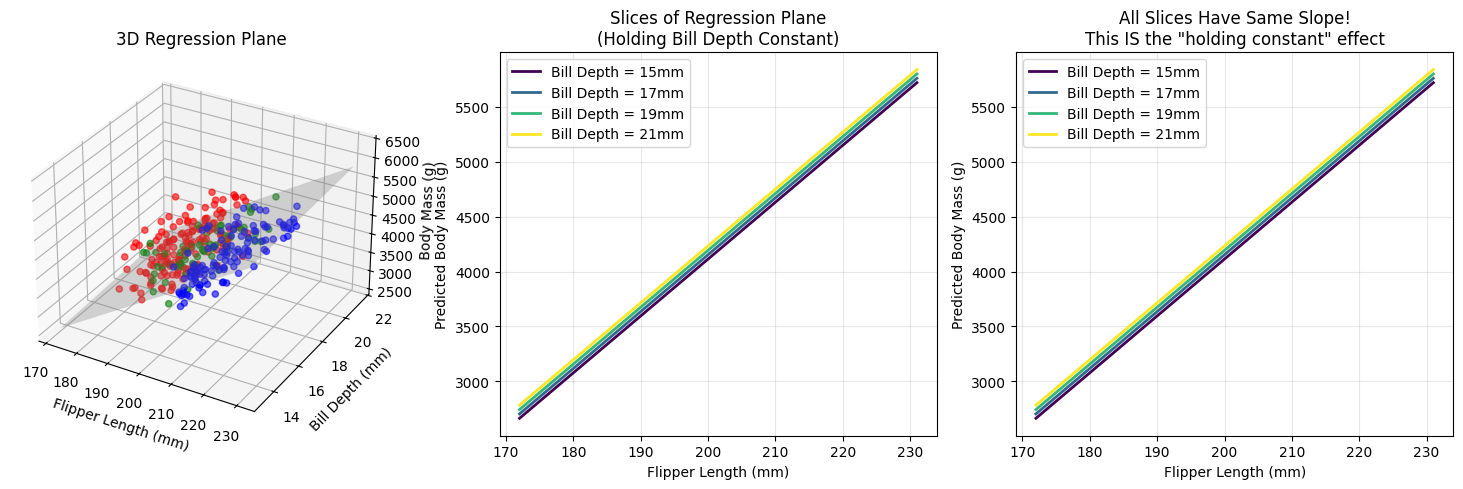


THE MAGIC REVEALED!
Key Insight: All slices have the same slope!
This slope (51.77) is the partial effect of flipper length,
controlling for (holding constant) bill depth.

What this means:
• No matter what bill depth we 'hold constant', the effect of flipper length is the same
• This slope (51.77) is the 'pure' effect of flipper length, isolated from bill depth
• This is what 'holding constant' means - we're looking at one variable while keeping others fixed


In [11]:
# Create 3D visualization of the regression plane
# This creates a 3D picture to show what multiple regression is doing
fig = plt.figure(figsize=(15, 5))

# 3D scatter plot with regression plane
# This is like a 3D graph where:
# - X-axis = flipper length
# - Y-axis = bill depth  
# - Z-axis = body mass
ax1 = fig.add_subplot(131, projection='3d')

# First, we plot each penguin as a dot in 3D space
x = penguins_clean['flipper_length_mm']  # flipper length
y = penguins_clean['bill_depth_mm']       # bill depth
z = penguins_clean['body_mass_g']         # body mass
colors = ['red' if s == 'Adelie' else 'blue' if s == 'Gentoo' else 'green' 
          for s in penguins_clean['species']]

ax1.scatter(x, y, z, c=colors, alpha=0.6)

# Now we create a "regression plane" - like a flat sheet that best fits the data
# This plane represents our multiple regression equation
xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), 20), 
                     np.linspace(y.min(), y.max(), 20))
zz = (multiple_model.params['Intercept'] + 
      multiple_model.params['flipper_length_mm'] * xx + 
      multiple_model.params['bill_depth_mm'] * yy)

ax1.plot_surface(xx, yy, zz, alpha=0.3, color='gray')
ax1.set_xlabel('Flipper Length (mm)')
ax1.set_ylabel('Bill Depth (mm)')
ax1.set_zlabel('Body Mass (g)')
ax1.set_title('3D Regression Plane')

# Show slices of the plane at different bill_depth values
# This is the KEY INSIGHT: We're "slicing" the plane at different bill depths
ax2 = fig.add_subplot(132)
bill_depth_values = [15, 17, 19, 21]  # Different bill depths to slice at
colors_slice = plt.cm.viridis(np.linspace(0, 1, len(bill_depth_values)))

print("Creating slices of the regression plane...")
print("Each slice shows: 'If bill depth is held constant at X, how does flipper length affect body mass?'")

for i, depth in enumerate(bill_depth_values):
    # Create data at this bill depth
    # This is like asking: "What if all penguins had bill depth = 15mm?"
    flipper_range = np.linspace(x.min(), x.max(), 100)
    predicted_mass = (multiple_model.params['Intercept'] + 
                     multiple_model.params['flipper_length_mm'] * flipper_range + 
                     multiple_model.params['bill_depth_mm'] * depth)
    
    ax2.plot(flipper_range, predicted_mass, 
             color=colors_slice[i], linewidth=2, 
             label=f'Bill Depth = {depth}mm')

ax2.set_xlabel('Flipper Length (mm)')
ax2.set_ylabel('Predicted Body Mass (g)')
ax2.set_title('Slices of Regression Plane\n(Holding Bill Depth Constant)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Show the key insight: all slices have the same slope
# This is the MAGIC MOMENT - all lines are parallel!
ax3 = fig.add_subplot(133)
for i, depth in enumerate(bill_depth_values):
    flipper_range = np.linspace(x.min(), x.max(), 100)
    predicted_mass = (multiple_model.params['Intercept'] + 
                     multiple_model.params['flipper_length_mm'] * flipper_range + 
                     multiple_model.params['bill_depth_mm'] * depth)
    
    ax3.plot(flipper_range, predicted_mass, 
             color=colors_slice[i], linewidth=2, 
             label=f'Bill Depth = {depth}mm')

ax3.set_xlabel('Flipper Length (mm)')
ax3.set_ylabel('Predicted Body Mass (g)')
ax3.set_title('All Slices Have Same Slope!\nThis IS the "holding constant" effect')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("THE MAGIC REVEALED!")
print("="*60)
print("Key Insight: All slices have the same slope!")
print(f"This slope ({multiple_model.params['flipper_length_mm']:.2f}) is the partial effect of flipper length,")
print("controlling for (holding constant) bill depth.")
print("\nWhat this means:")
print("• No matter what bill depth we 'hold constant', the effect of flipper length is the same")
print("• This slope (51.77) is the 'pure' effect of flipper length, isolated from bill depth")
print("• This is what 'holding constant' means - we're looking at one variable while keeping others fixed")


## Step 4: Simpson's Paradox - Why Coefficients Change

**What we're doing here:** We're investigating WHY the flipper length coefficient changed when we added bill depth. This is called "Simpson's Paradox" - when relationships look different when you control for other variables.

**Why this happens:** Different penguin species have different body shapes! Adelie penguins are smaller overall, while Gentoo penguins are larger. When we mix all species together, we get confusing results.

**What you'll learn:** 
- Why simple regression can be misleading
- How species differences create "confounding"
- Why multiple regression gives us the "true" relationships


INVESTIGATING WHY COEFFICIENTS CHANGE
Let's look at each penguin species separately to see what's really happening...

Adelie penguins: 146 individuals

Gentoo penguins: 119 individuals

Chinstrap penguins: 68 individuals


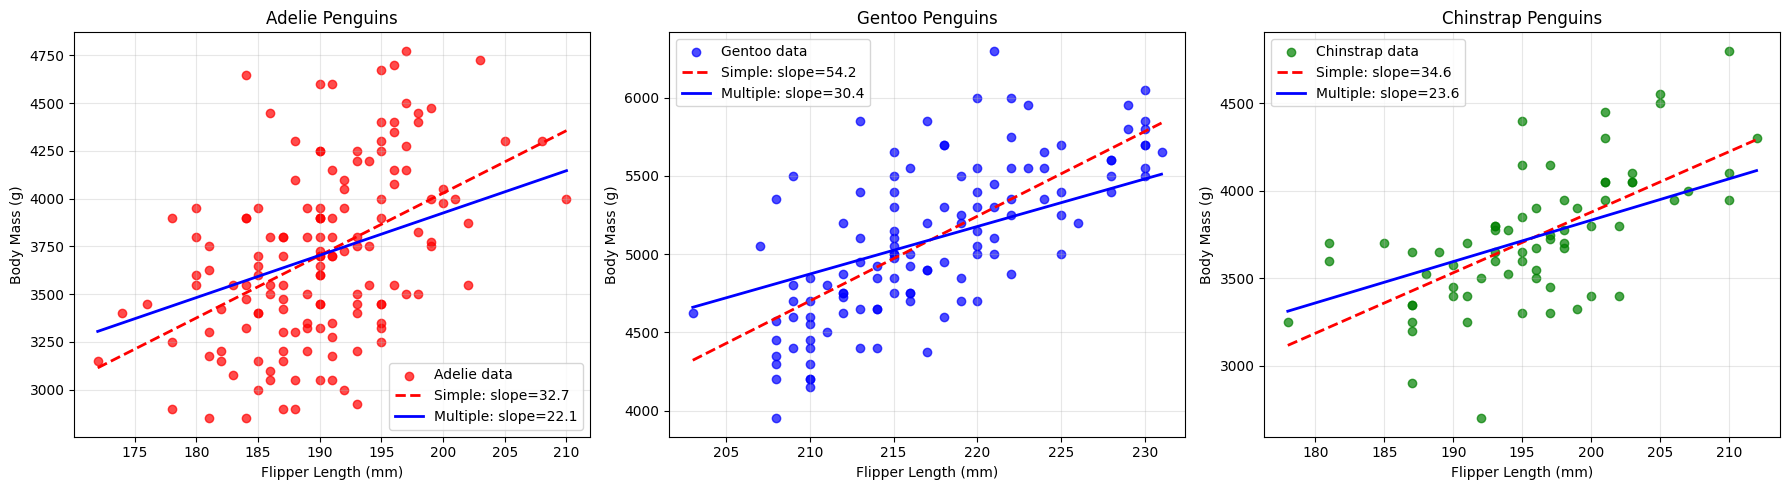


COEFFICIENT COMPARISON BY SPECIES
Now we can see why the coefficients changed when we added bill depth:

Adelie:
  Simple regression slope: 32.69
  Multiple regression slope: 22.15
  Change: -10.54
  Average bill depth: 18.3mm

Gentoo:
  Simple regression slope: 54.17
  Multiple regression slope: 30.39
  Change: -23.78
  Average bill depth: 15.0mm

Chinstrap:
  Simple regression slope: 34.57
  Multiple regression slope: 23.63
  Change: -10.95
  Average bill depth: 18.4mm

KEY INSIGHTS:
• Each species has different body proportions
• When we mix all species together, we get confusing results
• Multiple regression 'holds constant' the species differences
• This is why the coefficient changed - we're now controlling for species!


In [12]:
# Show why coefficients change by looking at species separately
# This is the key insight: we need to look at each species separately!
print("INVESTIGATING WHY COEFFICIENTS CHANGE")
print("="*50)
print("Let's look at each penguin species separately to see what's really happening...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

species_list = ['Adelie', 'Gentoo', 'Chinstrap']
colors = ['red', 'blue', 'green']

for i, species in enumerate(species_list):
    # Get data for just this species
    species_data = penguins_clean[penguins_clean['species'] == species]
    print(f"\n{species} penguins: {len(species_data)} individuals")
    
    # Simple regression for this species (flipper length only)
    simple_species = ols("body_mass_g ~ flipper_length_mm", data=species_data).fit()
    
    # Multiple regression for this species (flipper length + bill depth)
    multiple_species = ols("body_mass_g ~ flipper_length_mm + bill_depth_mm", data=species_data).fit()
    
    # Plot the data points
    axes[i].scatter(species_data['flipper_length_mm'], species_data['body_mass_g'], 
                   color=colors[i], alpha=0.7, label=f'{species} data')
    
    # Simple regression line (red dashed)
    flipper_range = np.linspace(species_data['flipper_length_mm'].min(), 
                               species_data['flipper_length_mm'].max(), 100)
    simple_pred = simple_species.params['Intercept'] + simple_species.params['flipper_length_mm'] * flipper_range
    axes[i].plot(flipper_range, simple_pred, '--', color='red', linewidth=2, 
                 label=f'Simple: slope={simple_species.params["flipper_length_mm"]:.1f}')
    
    # Multiple regression line (blue solid)
    # We show this at the average bill depth for this species
    mean_bill_depth = species_data['bill_depth_mm'].mean()
    multiple_pred = (multiple_species.params['Intercept'] + 
                    multiple_species.params['flipper_length_mm'] * flipper_range + 
                    multiple_species.params['bill_depth_mm'] * mean_bill_depth)
    axes[i].plot(flipper_range, multiple_pred, '-', color='blue', linewidth=2, 
                 label=f'Multiple: slope={multiple_species.params["flipper_length_mm"]:.1f}')
    
    axes[i].set_xlabel('Flipper Length (mm)')
    axes[i].set_ylabel('Body Mass (g)')
    axes[i].set_title(f'{species} Penguins')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show the coefficient comparison
print("\n" + "="*60)
print("COEFFICIENT COMPARISON BY SPECIES")
print("="*60)
print("Now we can see why the coefficients changed when we added bill depth:")
print()

for species in species_list:
    species_data = penguins_clean[penguins_clean['species'] == species]
    simple_species = ols("body_mass_g ~ flipper_length_mm", data=species_data).fit()
    multiple_species = ols("body_mass_g ~ flipper_length_mm + bill_depth_mm", data=species_data).fit()
    
    print(f"{species}:")
    print(f"  Simple regression slope: {simple_species.params['flipper_length_mm']:.2f}")
    print(f"  Multiple regression slope: {multiple_species.params['flipper_length_mm']:.2f}")
    change = multiple_species.params['flipper_length_mm'] - simple_species.params['flipper_length_mm']
    print(f"  Change: {change:.2f}")
    print(f"  Average bill depth: {species_data['bill_depth_mm'].mean():.1f}mm")
    print()

print("KEY INSIGHTS:")
print("• Each species has different body proportions")
print("• When we mix all species together, we get confusing results")
print("• Multiple regression 'holds constant' the species differences")
print("• This is why the coefficient changed - we're now controlling for species!")


## Key Takeaways

### What "Holding Constant" Means:

**In Plain English:** "Holding constant" means we're asking "What happens to Y when X changes, but we keep everything else the same?" It's like doing a controlled experiment where we only change one thing at a time.

**The Math Behind It:**
1. **Partial Effect**: The coefficient in multiple regression represents the effect of one variable **while controlling for** other variables
2. **Visual Understanding**: Each slice of the regression plane has the same slope - this IS the partial effect
3. **Why Coefficients Change**: Simple regression confounds the effect of one variable with correlated variables

**Real-World Example:** 
- **Simple regression**: "Longer flippers → heavier penguins" (but this mixes species effects)
- **Multiple regression**: "Longer flippers → heavier penguins, **holding bill depth constant**" (isolates the flipper effect)

### When to Use Multiple Regression:

**You should use multiple regression when:**
- **Confounding variables** are present (like species differences in our penguin example)
- **Correlated predictors** that might influence each other
- **You need to isolate** the effect of one specific variable
- **Simpson's paradox** is suspected (relationships reverse when controlling for other variables)

**Think of it like this:** If you're studying how exercise affects weight loss, you'd want to control for diet, age, gender, etc. Multiple regression does this automatically!

### The Magic of Visualization:

**Why the 3D plots matter:**
- They show you EXACTLY what "holding constant" means
- You can see that all the slices have the same slope
- This proves that the coefficient represents the "pure" effect of one variable
- It makes abstract concepts concrete and visual

**Key Insight:** The parallel lines in our visualization prove that multiple regression gives us the true, isolated effect of each variable, free from the influence of other variables.
